## Aplicación de la Metodología CRISP-DM

### Comprensión del Negocio:

El objetivo del proyecto es construir un modelo de clasificación de imágenes para identificar diferentes especies de aves a partir de imágenes. 

### Comprensión de los Datos:

Las imágenes de entrenamiento pertenecen a diversas especies de aves. Analizar la distribución de clases es importante para evitar sesgos. Como observamos en la matriz de confusión, algunas clases están mejor representadas que otras, lo cual afecta el rendimiento del modelo en identificar las especies menos comunes.

Las imagenes se obtuvieron del buscador de Google y de la app eBird

### Preparación de los Datos:

Durante la fase de preparación se redimensionaron las imagenes, se recortaron, se les quito el fondo y luego se les aplico el fondo de color azul

Para el entrenamiento se usaron imagenes sin fondo

#### Se importan librerias requeridas

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### Construcción del modelo

##### Se definen los data set de entrenamiento y validacion

In [2]:
train_data_dir = 'dataset-ajustado-150/train'  
validation_data_dir = 'dataset-ajustado-150/valid'

In [3]:
width_shape = 224
height_shape = 224
batch_size = 32

Se aplicaron técnicas de aumento de datos como rotación, zoom, desplazamiento, etc. Esto ayuda a mejorar la capacidad del modelo para generalizar. Sin embargo, podría ser necesario revisar si ciertas clases necesitan un aumento de datos específico (por ejemplo, si algunas especies tienen menos imágenes disponibles).Se definen las rutas de los datos y se establecen parámetros como el tamaño de imagen (224x224) y el tamaño de lote (32).

### Modelado

Se utilizó el modelo VGG16, el cual es adecuado para la clasificación de imágenes complejas. Sin embargo, los resultados sugieren que tal vez sea necesario ajustar los hiperparámetros o incluso probar otros modelos como ResNet o EfficientNet para mejorar el rendimiento.



In [4]:
# Definir el generador de imágenes para el conjunto de entrenamiento con aumentos de datos
train_datagen = ImageDataGenerator(  
    rotation_range=20,               # Rango de grados para rotación aleatoria
    zoom_range=0.2,                  # Rango de zoom aleatorio
    width_shift_range=0.1,           # Rango de desplazamiento horizontal aleatorio
    height_shift_range=0.1,          # Rango de desplazamiento vertical aleatorio
    horizontal_flip=True,            # Volteo horizontal aleatorio
    vertical_flip=False,             # No se aplica volteo vertical
    preprocessing_function=preprocess_input)  # Función de preprocesamiento

# Definir el generador de imágenes para el conjunto de validación con los mismos aumentos de datos
valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

# Crear un generador de lotes de imágenes para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                  # Directorio que contiene las imágenes de entrenamiento
    target_size=(width_shape, height_shape),  # Tamaño al que se redimensionarán las imágenes
    batch_size=batch_size,           # Tamaño del lote
    class_mode='categorical')        # Modo de clasificación para imágenes categóricas

# Crear un generador de lotes de imágenes para el conjunto de validación
validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,             # Directorio que contiene las imágenes de validación
    target_size=(width_shape, height_shape),  # Tamaño al que se redimensionarán las imágenes
    batch_size=batch_size,           # Tamaño del lote
    class_mode='categorical')        # Modo de clasificación para imágenes categóricas


Found 4546 images belonging to 44 classes.
Found 1299 images belonging to 44 classes.


Se configura un modelo de clasificación de imágenes usando VGG16. Son 5949 muestras para entrenamiento, 1299 para validacion, 44 clases y 50 épocas para el entrenamiento.

In [5]:
# Definir el número de muestras de entrenamiento y validación
nb_train_samples = 21786 
nb_validation_samples = 6225 
num_classes = 44  # Cambia este valor según el número de clases en tu conjunto de datos
epochs = 50  # Cambia este valor según tus necesidades

# Definir la entrada de la red neuronal con el tamaño de las imágenes
image_input = Input(shape=(width_shape, height_shape, 3))

# Cargar el modelo VGG16 preentrenado con pesos ajustados desde ImageNet
model = VGG16(input_tensor=image_input, include_top=True, weights='imagenet')

# Obtener la salida de la penúltima capa densa del modelo VGG16 (fc2)
last_layer = model.get_layer('fc2').output

# Añadir una nueva capa densa al final del modelo para la clasificación multiclase con regularización L2 (Evita sobreajuste)
out = Dense(num_classes, activation='softmax', kernel_regularizer='l2', name='output')(last_layer)

# Crear un nuevo modelo personalizado que toma la entrada de la imagen y produce la salida clasificada
custom_vgg_model = Model(image_input, out)

# Congelar todas las capas del modelo, excepto la capa densa añadida
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

# Compilar el modelo con una función de pérdida, optimizador y métricas especificadas
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


# Mostrar un resumen del modelo que incluye la arquitectura y el número de parámetros
custom_vgg_model.summary()

# Entrenar el modelo utilizando generadores de datos para el conjunto de entrenamiento y validación
model_history = custom_vgg_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,  # Número de pasos por época de entrenamiento
    validation_steps=nb_validation_samples//batch_size)  # Número de pasos por época de validación


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 44)             │       180,268 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,440,812 (512.85 MB)

 Trainable params: 180,268 (704.17 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Epoch 1/50


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/680 ━━━━━━━━━━━━━━━━━━━━ 42:18 5s/step - accuracy: 0.0844 - loss: 4.8526

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


680/680 ━━━━━━━━━━━━━━━━━━━━ 869s 1s/step - accuracy: 0.1404 - loss: 4.3748 - val_accuracy: 0.2664 - val_loss: 3.4845
Epoch 2/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 828s 1s/step - accuracy: 0.3805 - loss: 3.0521 - val_accuracy: 0.4180 - val_loss: 2.9114
Epoch 3/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 826s 1s/step - accuracy: 0.5018 - loss: 2.5830 - val_accuracy: 0.4942 - val_loss: 2.6217
Epoch 4/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 845s 1s/step - accuracy: 0.5696 - loss: 2.3143 - val_accuracy: 0.5019 - val_loss: 2.4911
Epoch 5/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 827s 1s/step - accuracy: 0.6096 - loss: 2.1228 - val_accuracy: 0.5381 - val_loss: 2.3469
Epoch 6/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 898s 1s/step - accuracy: 0.6482 - loss: 1.9987 - val_accuracy: 0.5651 - val_loss: 2.2363
Epoch 7/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 940s 1s/step - accuracy: 0.6788 - loss: 1.8789 - val_accuracy: 0.6035 - val_loss: 2.1556
Epoch 8/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 931s 1s/step - accuracy: 0.6957 - loss: 1.7968 - val_accuracy: 0.619

Se guarda el modelo entrenado

In [6]:
import os

# Nombre base del modelo
model_name = "model_VGG16_v_remove_background"

# Extensión del archivo
file_extension = ".keras"

# Directorio donde se guardarán los modelos
model_directory = "models/"

# Inicializar contador
counter = 1

# Generar el nombre completo del archivo
file_name = model_name + file_extension

ruta=model_directory + file_name
print(ruta)
# Verificar si el modelo ya está guardado
while os.path.exists(model_directory + file_name):
    
    # Si el archivo existe, agregar un número al final del nombre del modelo
    file_name = f"{model_name}{counter}{file_extension}"
    counter += 1

# Guardar el modelo con el nombre único en el directorio correcto
custom_vgg_model.save(model_directory + file_name)

models/model_VGG16_v_remove_background.keras


#### Se ajusta el codigo para realiar la representacion de las metricas  de perdida y de presición

In [7]:
def plotTraining(hist, epochs, typeData):

    # Seleccionar la figura y establecer el tamaño
    # Dependiendo del tipo de datos (loss o accuracy), se elige la figura correspondiente
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)


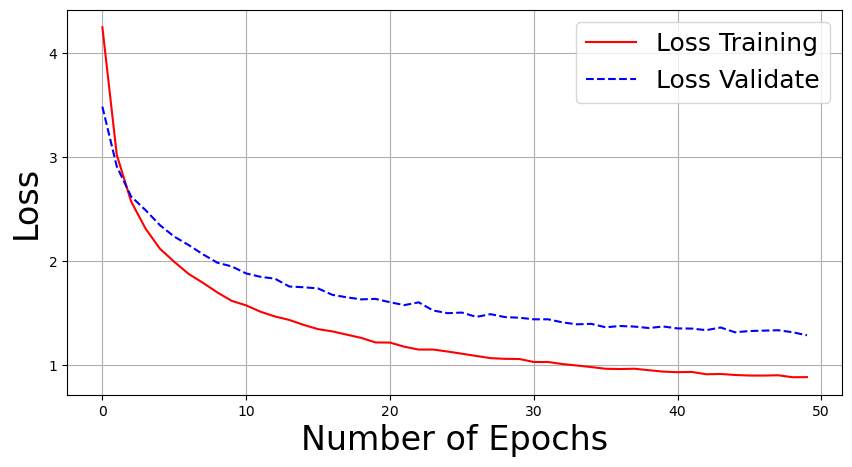

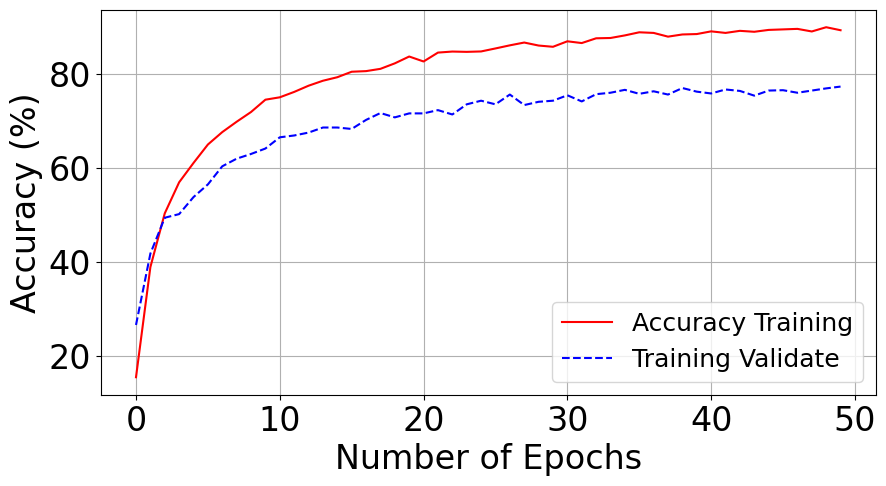

In [8]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

En el primer gráfico de pérdida, el hecho de que las pérdidas disminuyan con las épocas es positivo, pero la diferencia entre las pérdidas de entrenamiento y validación puede sugerir sobreajuste.
En el segundo gráfico de precisión, la brecha entre las precisiones de entrenamiento y validación también indica que el modelo se está adaptando demasiado a los datos de entrenamiento y no generaliza tan bien a los datos de validación.

In [10]:
ruta = r"dataset-ajustado-150\train"

# Obteniendo los nombres de las carpetas y almacenándolos en una lista
names = [nombre for nombre in os.listdir(ruta) if os.path.isdir(os.path.join(ruta, nombre))]


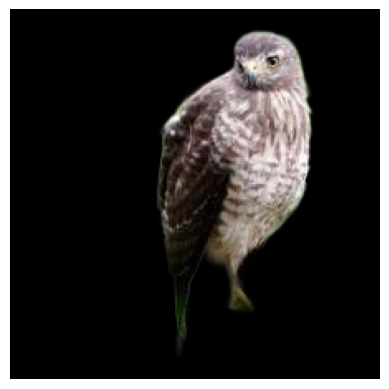

In [11]:
# Ruta de la imagen
imaget_path = r"dataset-ajustado-150\test\Aguililla Caminera\nobg_resize_aguililla-caminera-21.png"

# Leer la imagen con OpenCV - la imagen es de buho cafe 
imagen = cv2.imread(imaget_path)

# Convertir de BGR a RGB para mostrarla correctamente con matplotlib
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con matplotlib
plt.imshow(imagen_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()

### Predicción de Imagen Utilizando un Modelo VGG16 Preentrenado

Se carga el modelo VGG16 ajustado, que ha sido previamente entrenado para identificar diferentes clases.

Se lee la imagen de prueba y se ajusta a las dimensiones requeridas (224x224 píxeles). Luego, se aplican transformaciones necesarias para que la imagen sea compatible con el modelo (preprocess_input).

La imagen preprocesada se pasa al modelo para obtener la clase predicha.

Finalmente, se muestra la clase predicha, el porcentaje de confianza de la predicción, y se presenta la imagen junto con su resultado.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Clase predicha: buho cara oscura
Porcentaje de confianza: 32.07%


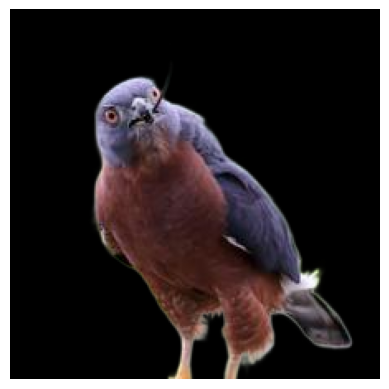

In [33]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model


# Cargar el modelo
modelt = load_model('models/model_VGG16_v_remove_background.keras')
#modelt = custom_vgg_model

# Ruta de la imagen de prueba
#imaget_path = "ImagenPrueba_sin_fondo.jpg"

# Leer la imagen, cambiar tamaño y preprocesar
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)

# Obtener las predicciones del modelo
preds = modelt.predict(xt)

# Obtener la clase predicha y su porcentaje de confianza
predicted_class_index = np.argmax(preds)
predicted_class_name = names[predicted_class_index]
confidence_percentage = preds[0][predicted_class_index] * 100

# Imprimir el resultado
print(f'Clase predicha: {predicted_class_name}')
print(f'Porcentaje de confianza: {confidence_percentage:.2f}%')

# Mostrar la imagen
plt.imshow(cv2.cvtColor(np.asarray(imaget), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Reporte de metricas para cada clase del conjunto de datos

Es util  para entender como esta funcionando el modelo y para identificar en las que el modelo tiene mas dificultades

In [13]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_data_dir = 'dataset-ajustado-150/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model(model_directory + file_name)

predictions = custom_Model.predict(test_generator)


y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)



print(metrics.classification_report(y_real,y_pred, digits = 4))

Found 650 images belonging to 44 classes.
21/21 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step
              precision    recall  f1-score   support

           0     0.1176    0.2105    0.1509        19
           1     0.0833    0.0909    0.0870        11
           2     0.5000    0.0667    0.1176        15
           3     0.5000    0.1579    0.2400        19
           4     0.6364    0.5833    0.6087        12
           5     0.6000    0.3333    0.4286        18
           6     0.7500    0.3333    0.4615         9
           7     0.0909    0.3333    0.1429        15
           8     0.6429    0.5625    0.6000        16
           9     0.2609    0.7500    0.3871        16
          10     0.6667    0.1333    0.2222        15
          11     0.2500    0.2667    0.2581        15
          12     0.2000    0.0435    0.0714        23
          13     1.0000    0.1176    0.2105        17
          14     0.6667    0.2000    0.3077        10
          15     0.5000    0.3125    0.3846        16


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clase 28, que tiene un f1-score de 0.0000 y recall también de 0.0000, lo cual sugiere que el modelo no puede clasificar ninguna instancia de esta clase.

Clase 1 y Clase 2, que presentan valores de precisión, recall y f1-score muy bajos, lo cual indica que el modelo tiene dificultades tanto para identificar las instancias correctas como para ser preciso en sus predicciones.

# todos los modelos

In [15]:
# Importaciones necesarias
import time
import psutil
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el número de muestras de entrenamiento y validación
nb_train_samples = 4546 
nb_validation_samples = 1299 

# Definir el número de épocas
epochs = 50

# Definir el tamaño de las imágenes
width_shape = 224
height_shape = 224

# Definir el número de clases
num_classes = 44  # Ajustar según el número de clases en tu dataset

# Directorios de datos de entrenamiento y validación
train_data_dir = 'dataset-ajustado-150/train'  
validation_data_dir = 'dataset-ajustado-150/valid'

# Función para crear y entrenar el modelo
def create_and_train_vgg16_model(learning_rate, l2_regularization, batch_size):
    # Crear generadores de datos con el batch_size proporcionado
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=preprocess_input
    )

    valid_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(width_shape, height_shape),
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(width_shape, height_shape),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Definir la entrada de la red neuronal con el tamaño de las imágenes
    image_input = Input(shape=(width_shape, height_shape, 3))

    # Cargar el modelo VGG16 preentrenado con pesos ajustados desde ImageNet
    model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

    # Aplanar la salida del VGG16
    x = Flatten()(model.output)

    # Añadir una nueva capa densa al final del modelo para la clasificación multiclase con regularización L2
    out = Dense(num_classes, activation='softmax', kernel_regularizer='l2')(x)

    # Crear un nuevo modelo personalizado que toma la entrada de la imagen y produce la salida clasificada
    custom_vgg_model = Model(inputs=model.input, outputs=out)

    # Congelar todas las capas del modelo base VGG16
    for layer in model.layers:
        layer.trainable = False

    # Compilar el modelo con una función de pérdida, optimizador y métricas especificadas
    custom_vgg_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Mostrar un resumen del modelo que incluye la arquitectura y el número de parámetros
    custom_vgg_model.summary()

    # Medir el tiempo y el uso de CPU/memoria antes de entrenar
    start_time = time.time()
    start_cpu = psutil.cpu_percent(interval=None)
    start_memory = psutil.virtual_memory().used

    # Crear los callbacks para Early Stopping y guardar el mejor modelo
    checkpoint = ModelCheckpoint('best_model_v_remove_background.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

    # Entrenar el modelo utilizando generadores de datos para el conjunto de entrenamiento y validación
    model_history = custom_vgg_model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    # Medir el tiempo y el uso de CPU/memoria después de entrenar
    end_time = time.time()
    end_cpu = psutil.cpu_percent(interval=None)
    end_memory = psutil.virtual_memory().used

    # Calcular métricas de tiempo y uso de recursos
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    memory_usage = end_memory - start_memory

    print(f"Tiempo transcurrido para el entrenamiento: {elapsed_time} segundos")
    print(f"Uso de CPU durante el entrenamiento: {cpu_usage}%")
    print(f"Aumento en uso de memoria: {memory_usage / (1024 ** 3)} GB")

    return model_history, elapsed_time, cpu_usage, memory_usage

# Definir rangos de búsqueda para hiperparámetros
learning_rates = [0.0001, 0.0005, 0.001]
l2_regularizations = [0.01, 0.05, 0.1]
batch_sizes = [16, 32, 64]

# Variables para almacenar los mejores hiperparámetros y su rendimiento
best_val_accuracy = 0
best_hyperparams = {}

# Realizar la búsqueda de cuadrícula
for learning_rate in learning_rates:
    for l2_regularization in l2_regularizations:
        for batch_size in batch_sizes:
            # Crear y entrenar el modelo con los hiperparámetros actuales
            model_history, elapsed_time, cpu_usage, memory_usage = create_and_train_vgg16_model(learning_rate, l2_regularization, batch_size)
            
            # Obtener la mejor precisión de validación de esta combinación de hiperparámetros
            val_accuracy = np.max(model_history.history['val_accuracy'])
            
            # Imprimir los resultados
            print(f"Resultados para lr={learning_rate}, l2={l2_regularization}, batch_size={batch_size}:")
            print(f"Tiempo: {elapsed_time} segundos, CPU: {cpu_usage}%, Memoria: {memory_usage / (1024 ** 3)} GB")
            print(f"Precisión de validación: {val_accuracy}")
            
            # Actualizar los mejores hiperparámetros si la precisión de validación mejora
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparams = {
                    'learning_rate': learning_rate,
                    'l2_regularization': l2_regularization,
                    'batch_size': batch_size,
                    'val_accuracy': val_accuracy,
                    'elapsed_time': elapsed_time,
                    'cpu_usage': cpu_usage,
                    'memory_usage': memory_usage
                }

# Imprimir los mejores hiperparámetros y su rendimiento
print("Mejores hiperparámetros encontrados:")
print(best_hyperparams)



Found 4546 images belonging to 44 classes.
Found 1299 images belonging to 44 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1183 - loss: 15.0417
Epoch 1: val_accuracy improved from -inf to 0.33719, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 829s 3s/step - accuracy: 0.1186 - loss: 15.0293 - val_accuracy: 0.3372 - val_loss: 7.8808
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:28 2s/step - accuracy: 0.2500 - loss: 9.2618

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.33719
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2500 - loss: 9.2618 - val_accuracy: 0.3333 - val_loss: 15.0717
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4401 - loss: 5.9326
Epoch 3: val_accuracy improved from 0.33719 to 0.46759, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.4402 - loss: 5.9308 - val_accuracy: 0.4676 - val_loss: 5.9148
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 11:02 2s/step - accuracy: 0.6250 - loss: 3.3440
Epoch 4: val_accuracy improved from 0.46759 to 0.66667, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6250 - loss: 3.3440 - val_accuracy: 0.6667 - val_loss: 6.6396
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5886 - loss: 3.8947
Epoch 5: val_accuracy did not improve from 0.66667
284/284 ━━━━━━━━━━━━━━━━━━━━ 820s 3s/step - accuracy: 0.5887 - loss:

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0767 - loss: 16.9529
Epoch 1: val_accuracy improved from -inf to 0.26484, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 812s 6s/step - accuracy: 0.0772 - loss: 16.9280 - val_accuracy: 0.2648 - val_loss: 9.2580
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - accuracy: 0.2188 - loss: 9.0457
Epoch 2: val_accuracy did not improve from 0.26484
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2188 - loss: 9.0457 - val_accuracy: 0.1053 - val_loss: 11.9131
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3685 - loss: 6.9164
Epoch 3: val_accuracy improved from 0.26484 to 0.40234, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 810s 6s/step - accuracy: 0.3686 - loss: 6.9129 - val_accuracy: 0.4023 - val_loss: 6.8142
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:45 5s/step - accuracy: 0.5000 - loss: 4.2496
Epoch 4: val_accuracy improved f

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0562 - loss: 17.9926
Epoch 1: val_accuracy improved from -inf to 0.20781, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 807s 11s/step - accuracy: 0.0570 - loss: 17.9450 - val_accuracy: 0.2078 - val_loss: 10.3345
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - accuracy: 0.2500 - loss: 8.7186
Epoch 2: val_accuracy did not improve from 0.20781
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.2500 - loss: 8.7186 - val_accuracy: 0.1053 - val_loss: 8.0288
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3159 - loss: 7.9244
Epoch 3: val_accuracy improved from 0.20781 to 0.34062, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 806s 11s/step - accuracy: 0.3162 - loss: 7.9170 - val_accuracy: 0.3406 - val_loss: 7.6933
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - accuracy: 0.4219 - loss: 6.5078
Epoch 4: val_accuracy did not improve from

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1195 - loss: 15.4836
Epoch 1: val_accuracy improved from -inf to 0.34259, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - accuracy: 0.1198 - loss: 15.4705 - val_accuracy: 0.3426 - val_loss: 7.9087
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.3125 - loss: 4.9279
Epoch 2: val_accuracy did not improve from 0.34259
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3125 - loss: 4.9279 - val_accuracy: 0.3333 - val_loss: 9.8916
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4439 - loss: 5.8053
Epoch 3: val_accuracy improved from 0.34259 to 0.46991, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 817s 3s/step - accuracy: 0.4440 - loss: 5.8035 - val_accuracy: 0.4699 - val_loss: 5.7852
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:46 2s/step - accuracy: 0.4375 - loss: 5.3720
Epoch 4: val_accuracy improved fr

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0896 - loss: 16.5026
Epoch 1: val_accuracy improved from -inf to 0.26641, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 810s 6s/step - accuracy: 0.0901 - loss: 16.4783 - val_accuracy: 0.2664 - val_loss: 9.2492
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - accuracy: 0.2812 - loss: 9.4712
Epoch 2: val_accuracy improved from 0.26641 to 0.31579, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2812 - loss: 9.4712 - val_accuracy: 0.3158 - val_loss: 8.4222
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3855 - loss: 6.6749
Epoch 3: val_accuracy improved from 0.31579 to 0.41250, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 811s 6s/step - accuracy: 0.3856 - loss: 6.6729 - val_accuracy: 0.4125 - val_loss: 6.4734
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - accuracy

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0681 - loss: 17.8549
Epoch 1: val_accuracy improved from -inf to 0.23281, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 811s 11s/step - accuracy: 0.0687 - loss: 17.8086 - val_accuracy: 0.2328 - val_loss: 9.7735
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 9:52 8s/step - accuracy: 0.2188 - loss: 10.2095
Epoch 2: val_accuracy did not improve from 0.23281
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2188 - loss: 10.2095 - val_accuracy: 0.2105 - val_loss: 10.1379
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3017 - loss: 8.2382
Epoch 3: val_accuracy improved from 0.23281 to 0.33203, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 806s 11s/step - accuracy: 0.3022 - loss: 8.2294 - val_accuracy: 0.3320 - val_loss: 7.4314
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:11 9s/step - accuracy: 0.3594 - loss: 7.1789
Epoch 4: val_accuracy improved from 0.332

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1168 - loss: 15.2491
Epoch 1: val_accuracy improved from -inf to 0.35262, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 829s 3s/step - accuracy: 0.1172 - loss: 15.2365 - val_accuracy: 0.3526 - val_loss: 7.6517
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 11:07 2s/step - accuracy: 0.3125 - loss: 6.7071
Epoch 2: val_accuracy did not improve from 0.35262
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3125 - loss: 6.7071 - val_accuracy: 0.3333 - val_loss: 2.0009
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4412 - loss: 5.7776
Epoch 3: val_accuracy improved from 0.35262 to 0.49460, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - accuracy: 0.4413 - loss: 5.7767 - val_accuracy: 0.4946 - val_loss: 5.3441
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:25 2s/step - accuracy: 0.5000 - loss: 3.5599
Epoch 4: val_accuracy did not imp

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0848 - loss: 17.2337
Epoch 1: val_accuracy improved from -inf to 0.27109, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 812s 6s/step - accuracy: 0.0853 - loss: 17.2055 - val_accuracy: 0.2711 - val_loss: 8.6877
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - accuracy: 0.3750 - loss: 7.5589
Epoch 2: val_accuracy did not improve from 0.27109
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3750 - loss: 7.5589 - val_accuracy: 0.2632 - val_loss: 7.4449
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3652 - loss: 6.9571
Epoch 3: val_accuracy improved from 0.27109 to 0.40938, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 811s 6s/step - accuracy: 0.3654 - loss: 6.9534 - val_accuracy: 0.4094 - val_loss: 6.2721
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - accuracy: 0.5938 - loss: 3.6180
Epoch 4: val_accuracy did not impr

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0617 - loss: 18.2543
Epoch 1: val_accuracy improved from -inf to 0.22266, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 803s 11s/step - accuracy: 0.0624 - loss: 18.2053 - val_accuracy: 0.2227 - val_loss: 10.2680
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 9:49 8s/step - accuracy: 0.1875 - loss: 10.8035
Epoch 2: val_accuracy improved from 0.22266 to 0.36842, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.1875 - loss: 10.8035 - val_accuracy: 0.3684 - val_loss: 9.8711
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2897 - loss: 8.1915
Epoch 3: val_accuracy did not improve from 0.36842
71/71 ━━━━━━━━━━━━━━━━━━━━ 801s 11s/step - accuracy: 0.2901 - loss: 8.1838 - val_accuracy: 0.3477 - val_loss: 7.1587
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 9:46 8s/step - accuracy: 0.4375 - loss: 6.1008
Epoch 4: val_accuracy did not improve from

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2371 - loss: 17.8748
Epoch 1: val_accuracy improved from -inf to 0.45293, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - accuracy: 0.2374 - loss: 17.8663 - val_accuracy: 0.4529 - val_loss: 14.1124
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:28 2s/step - accuracy: 0.3750 - loss: 10.9871
Epoch 2: val_accuracy did not improve from 0.45293
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3750 - loss: 10.9871 - val_accuracy: 0.3333 - val_loss: 9.8405
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5861 - loss: 9.1460
Epoch 3: val_accuracy improved from 0.45293 to 0.57099, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 820s 3s/step - accuracy: 0.5861 - loss: 9.1465 - val_accuracy: 0.5710 - val_loss: 12.2224
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.8125 - loss: 3.8458
Epoch 4: val_accuracy did not

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2147 - loss: 16.7027
Epoch 1: val_accuracy improved from -inf to 0.46953, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 811s 6s/step - accuracy: 0.2155 - loss: 16.6804 - val_accuracy: 0.4695 - val_loss: 10.0600
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:04 4s/step - accuracy: 0.2812 - loss: 11.0598
Epoch 2: val_accuracy improved from 0.46953 to 0.52632, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.2812 - loss: 11.0598 - val_accuracy: 0.5263 - val_loss: 8.9248
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5816 - loss: 7.3520
Epoch 3: val_accuracy improved from 0.52632 to 0.59375, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.5817 - loss: 7.3501 - val_accuracy: 0.5938 - val_loss: 7.9765
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - accu

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1930 - loss: 16.4235
Epoch 1: val_accuracy improved from -inf to 0.46562, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 806s 11s/step - accuracy: 0.1946 - loss: 16.3687 - val_accuracy: 0.4656 - val_loss: 8.3474
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 9:44 8s/step - accuracy: 0.4688 - loss: 8.8411
Epoch 2: val_accuracy improved from 0.46562 to 0.63158, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4688 - loss: 8.8411 - val_accuracy: 0.6316 - val_loss: 3.5230
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5698 - loss: 6.1429
Epoch 3: val_accuracy did not improve from 0.63158
71/71 ━━━━━━━━━━━━━━━━━━━━ 799s 11s/step - accuracy: 0.5701 - loss: 6.1360 - val_accuracy: 0.5727 - val_loss: 6.9147
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - accuracy: 0.5938 - loss: 5.9708
Epoch 4: val_accuracy did not improve from 0

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2281 - loss: 17.3661
Epoch 1: val_accuracy improved from -inf to 0.47145, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 820s 3s/step - accuracy: 0.2285 - loss: 17.3566 - val_accuracy: 0.4715 - val_loss: 12.5035
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:18 2s/step - accuracy: 0.5625 - loss: 8.5974
Epoch 2: val_accuracy did not improve from 0.47145
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5625 - loss: 8.5974 - val_accuracy: 0.3333 - val_loss: 7.0445
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6063 - loss: 8.3425
Epoch 3: val_accuracy improved from 0.47145 to 0.54167, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.6063 - loss: 8.3439 - val_accuracy: 0.5417 - val_loss: 11.9040
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:34 2s/step - accuracy: 0.3750 - loss: 21.9318
Epoch 4: val_accuracy improved

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2246 - loss: 15.8599
Epoch 1: val_accuracy improved from -inf to 0.45391, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 810s 6s/step - accuracy: 0.2253 - loss: 15.8376 - val_accuracy: 0.4539 - val_loss: 10.6552
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:03 4s/step - accuracy: 0.4375 - loss: 7.8531
Epoch 2: val_accuracy improved from 0.45391 to 0.63158, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4375 - loss: 7.8531 - val_accuracy: 0.6316 - val_loss: 5.1274
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5918 - loss: 7.1774
Epoch 3: val_accuracy did not improve from 0.63158
142/142 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.5919 - loss: 7.1755 - val_accuracy: 0.5727 - val_loss: 9.0867
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 11:04 5s/step - accuracy: 0.5938 - loss: 7.8048
Epoch 4: val_accuracy did not i

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1949 - loss: 16.3134
Epoch 1: val_accuracy improved from -inf to 0.45937, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 803s 11s/step - accuracy: 0.1965 - loss: 16.2598 - val_accuracy: 0.4594 - val_loss: 8.3777
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - accuracy: 0.3750 - loss: 9.7238
Epoch 2: val_accuracy improved from 0.45937 to 0.57895, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.3750 - loss: 9.7238 - val_accuracy: 0.5789 - val_loss: 7.6479
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5874 - loss: 5.6848
Epoch 3: val_accuracy did not improve from 0.57895
71/71 ━━━━━━━━━━━━━━━━━━━━ 799s 11s/step - accuracy: 0.5875 - loss: 5.6852 - val_accuracy: 0.5492 - val_loss: 7.7614
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - accuracy: 0.5312 - loss: 6.6117
Epoch 4: val_accuracy did not improve from 

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2399 - loss: 16.9650
Epoch 1: val_accuracy improved from -inf to 0.47994, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.2403 - loss: 16.9562 - val_accuracy: 0.4799 - val_loss: 11.9820
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 11:20 2s/step - accuracy: 0.4375 - loss: 17.9421
Epoch 2: val_accuracy improved from 0.47994 to 0.66667, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4375 - loss: 17.9421 - val_accuracy: 0.6667 - val_loss: 2.9382
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5856 - loss: 9.1237
Epoch 3: val_accuracy did not improve from 0.66667
284/284 ━━━━━━━━━━━━━━━━━━━━ 820s 3s/step - accuracy: 0.5856 - loss: 9.1240 - val_accuracy: 0.5525 - val_loss: 12.1702
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:18 2s/step - accuracy: 0.6250 - loss: 12.5242
Epoch 4: val_accuracy improv

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2062 - loss: 16.9424
Epoch 1: val_accuracy improved from -inf to 0.46797, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 814s 6s/step - accuracy: 0.2070 - loss: 16.9149 - val_accuracy: 0.4680 - val_loss: 10.1618
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:24 4s/step - accuracy: 0.5000 - loss: 8.7922
Epoch 2: val_accuracy did not improve from 0.46797
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5000 - loss: 8.7922 - val_accuracy: 0.4211 - val_loss: 13.9442
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5906 - loss: 7.0352
Epoch 3: val_accuracy improved from 0.46797 to 0.54531, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 809s 6s/step - accuracy: 0.5907 - loss: 7.0335 - val_accuracy: 0.5453 - val_loss: 8.9622
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - accuracy: 0.5625 - loss: 10.5811
Epoch 4: val_accuracy did not

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1903 - loss: 16.5321
Epoch 1: val_accuracy improved from -inf to 0.45078, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 807s 11s/step - accuracy: 0.1919 - loss: 16.4784 - val_accuracy: 0.4508 - val_loss: 9.0350
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - accuracy: 0.5312 - loss: 6.7459
Epoch 2: val_accuracy did not improve from 0.45078
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.5312 - loss: 6.7459 - val_accuracy: 0.2632 - val_loss: 14.8372
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5844 - loss: 6.0993
Epoch 3: val_accuracy improved from 0.45078 to 0.56563, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 803s 11s/step - accuracy: 0.5844 - loss: 6.1014 - val_accuracy: 0.5656 - val_loss: 7.2644
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - accuracy: 0.5156 - loss: 7.2554
Epoch 4: val_accuracy did not improve from

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2333 - loss: 27.9051
Epoch 1: val_accuracy improved from -inf to 0.44522, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.2337 - loss: 27.8976 - val_accuracy: 0.4452 - val_loss: 24.8404
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 11:54 3s/step - accuracy: 0.2500 - loss: 42.7206
Epoch 2: val_accuracy improved from 0.44522 to 0.66667, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2500 - loss: 42.7206 - val_accuracy: 0.6667 - val_loss: 17.9682
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5879 - loss: 17.4269
Epoch 3: val_accuracy did not improve from 0.66667
284/284 ━━━━━━━━━━━━━━━━━━━━ 826s 3s/step - accuracy: 0.5879 - loss: 17.4294 - val_accuracy: 0.5610 - val_loss: 23.2901
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:27 2s/step - accuracy: 0.4375 - loss: 19.8100
Epoch 4: val_accuracy did

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2410 - loss: 22.7444
Epoch 1: val_accuracy improved from -inf to 0.47813, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 823s 6s/step - accuracy: 0.2418 - loss: 22.7221 - val_accuracy: 0.4781 - val_loss: 16.6359
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:40 5s/step - accuracy: 0.5938 - loss: 14.4723
Epoch 2: val_accuracy did not improve from 0.47813
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5938 - loss: 14.4723 - val_accuracy: 0.2105 - val_loss: 18.7556
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5912 - loss: 12.2875
Epoch 3: val_accuracy improved from 0.47813 to 0.52188, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 821s 6s/step - accuracy: 0.5912 - loss: 12.2905 - val_accuracy: 0.5219 - val_loss: 18.7220
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - accuracy: 0.6875 - loss: 9.3037
Epoch 4: val_accuracy imp

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2179 - loss: 22.1710
Epoch 1: val_accuracy improved from -inf to 0.48203, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 817s 11s/step - accuracy: 0.2194 - loss: 22.1149 - val_accuracy: 0.4820 - val_loss: 12.8419
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - accuracy: 0.5781 - loss: 9.0682
Epoch 2: val_accuracy did not improve from 0.48203
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5781 - loss: 9.0682 - val_accuracy: 0.4737 - val_loss: 13.7551
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5982 - loss: 9.1835
Epoch 3: val_accuracy improved from 0.48203 to 0.55547, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 808s 11s/step - accuracy: 0.5983 - loss: 9.1819 - val_accuracy: 0.5555 - val_loss: 12.5417
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:11 9s/step - accuracy: 0.6406 - loss: 7.2831
Epoch 4: val_accuracy improved from 0.55

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2635 - loss: 26.6409
Epoch 1: val_accuracy improved from -inf to 0.46528, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 827s 3s/step - accuracy: 0.2638 - loss: 26.6387 - val_accuracy: 0.4653 - val_loss: 24.6424
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 10:45 2s/step - accuracy: 0.5000 - loss: 21.0310
Epoch 2: val_accuracy improved from 0.46528 to 0.66667, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5000 - loss: 21.0310 - val_accuracy: 0.6667 - val_loss: 63.6006
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5798 - loss: 17.9235
Epoch 3: val_accuracy did not improve from 0.66667
284/284 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - accuracy: 0.5798 - loss: 17.9259 - val_accuracy: 0.5370 - val_loss: 26.2032
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 11:04 2s/step - accuracy: 0.7500 - loss: 10.9427
Epoch 4: val_accuracy did

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2302 - loss: 23.9641
Epoch 1: val_accuracy improved from -inf to 0.48906, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 813s 6s/step - accuracy: 0.2310 - loss: 23.9438 - val_accuracy: 0.4891 - val_loss: 17.5840
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:37 5s/step - accuracy: 0.5625 - loss: 12.5201
Epoch 2: val_accuracy did not improve from 0.48906
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5625 - loss: 12.5201 - val_accuracy: 0.4737 - val_loss: 11.0600
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5913 - loss: 12.4610
Epoch 3: val_accuracy improved from 0.48906 to 0.53906, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 812s 6s/step - accuracy: 0.5913 - loss: 12.4649 - val_accuracy: 0.5391 - val_loss: 18.4815
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:22 4s/step - accuracy: 0.6250 - loss: 15.2738
Epoch 4: val_accuracy im

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2213 - loss: 21.9719
Epoch 1: val_accuracy improved from -inf to 0.48203, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 810s 11s/step - accuracy: 0.2230 - loss: 21.9124 - val_accuracy: 0.4820 - val_loss: 14.2131
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - accuracy: 0.4688 - loss: 13.3642
Epoch 2: val_accuracy did not improve from 0.48203
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.4688 - loss: 13.3642 - val_accuracy: 0.3158 - val_loss: 25.8580
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5914 - loss: 9.2748
Epoch 3: val_accuracy improved from 0.48203 to 0.58594, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 807s 11s/step - accuracy: 0.5914 - loss: 9.2795 - val_accuracy: 0.5859 - val_loss: 11.4287
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - accuracy: 0.7031 - loss: 8.0646
Epoch 4: val_accuracy did not improve 

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2398 - loss: 28.2601
Epoch 1: val_accuracy improved from -inf to 0.45448, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 834s 3s/step - accuracy: 0.2402 - loss: 28.2541 - val_accuracy: 0.4545 - val_loss: 26.0650
Epoch 2/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 11:59 3s/step - accuracy: 0.4375 - loss: 35.8419
Epoch 2: val_accuracy did not improve from 0.45448
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4375 - loss: 35.8419 - val_accuracy: 0.3333 - val_loss: 19.1970
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5683 - loss: 19.4393
Epoch 3: val_accuracy improved from 0.45448 to 0.57022, saving model to best_model_v_remove_background.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 830s 3s/step - accuracy: 0.5683 - loss: 19.4388 - val_accuracy: 0.5702 - val_loss: 22.6116
Epoch 4/50
  1/284 ━━━━━━━━━━━━━━━━━━━━ 11:00 2s/step - accuracy: 0.7500 - loss: 13.6337
Epoch 4: val_accuracy did

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2347 - loss: 23.0685
Epoch 1: val_accuracy improved from -inf to 0.49531, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 813s 6s/step - accuracy: 0.2355 - loss: 23.0441 - val_accuracy: 0.4953 - val_loss: 16.5865
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.4688 - loss: 25.6658
Epoch 2: val_accuracy improved from 0.49531 to 0.57895, saving model to best_model_v_remove_background.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4688 - loss: 25.6658 - val_accuracy: 0.5789 - val_loss: 14.8596
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5883 - loss: 13.1197
Epoch 3: val_accuracy did not improve from 0.57895
142/142 ━━━━━━━━━━━━━━━━━━━━ 811s 6s/step - accuracy: 0.5884 - loss: 13.1181 - val_accuracy: 0.5398 - val_loss: 18.2802
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 10:55 5s/step - accuracy: 0.6562 - loss: 12.2575
Epoch 4: val_accuracy di

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 44)             │     1,103,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2179 - loss: 21.7140
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 810s 11s/step - accuracy: 0.2196 - loss: 21.6521 - val_accuracy: 0.4875 - val_loss: 12.2893
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - accuracy: 0.6094 - loss: 14.8389
Epoch 2: val_accuracy did not improve from 0.48750
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6094 - loss: 14.8389 - val_accuracy: 0.4211 - val_loss: 7.4942
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5979 - loss: 8.8362
Epoch 3: val_accuracy improved from 0.48750 to 0.58828, saving model to best_model_v_remove_background.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 809s 11s/step - accuracy: 0.5981 - loss: 8.8404 - val_accuracy: 0.5883 - val_loss: 11.3641
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 9:54 8s/step - accuracy: 0.6250 - loss: 10.9598
Epoch 4: val_accuracy did not improve f

In [16]:

def plotTraining(hist, epochs, typeData):

    # Seleccionar la figura y establecer el tamaño
    # Dependiendo del tipo de datos (loss o accuracy), se elige la figura correspondiente
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)


In [19]:
import os
ruta = r"dataset-ajustado-150\train"

# Obteniendo los nombres de las carpetas y almacenándolos en una lista
names = [nombre for nombre in os.listdir(ruta) if os.path.isdir(os.path.join(ruta, nombre))]


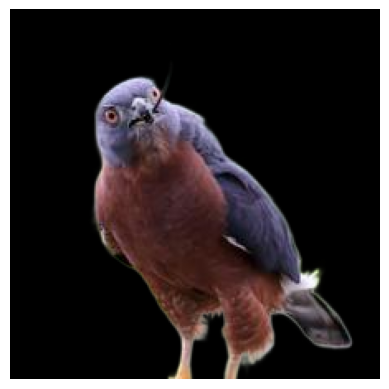

In [20]:
import cv2
import matplotlib.pyplot as plt

# Ruta de la imagen
imaget_path = r"dataset-ajustado-150\test\gavilan bidentado\nobg_resize_Gavilan bidentado-131.png"

# Leer la imagen con OpenCV - la imagen es de buho cafe 
imagen = cv2.imread(imaget_path)

# Convertir de BGR a RGB para mostrarla correctamente con matplotlib
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con matplotlib
plt.imshow(imagen_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Clase predicha: buho cafe
Porcentaje de confianza: 100.00%


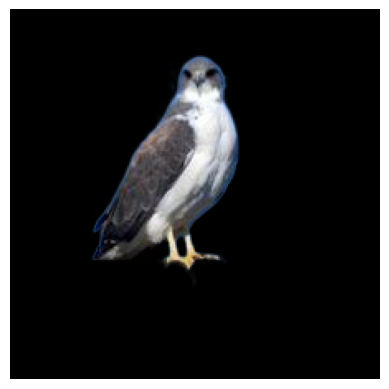

In [23]:
import numpy as np
import cv2
import os
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt

# Ruta al modelo guardado
model_path = 'best_model_v_remove_background.keras'

# Cargar el modelo entrenado
model = load_model(model_path)

# Ruta al directorio de entrenamiento para obtener los nombres de las clases
train_data_dir = r'dataset-ajustado-150\train'

# Obteniendo los nombres de las carpetas y almacenándolos en una lista
names = [nombre for nombre in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, nombre))]

# Ruta a la imagen que se desea predecir
image_path = r"dataset-ajustado-150\test\Aguililla Cola Blanca\nobg_resize_aguililla-cola blanca-5.png"

# Leer la imagen usando OpenCV
image = cv2.imread(image_path)

# Redimensionar la imagen al tamaño esperado por VGG16 (224x224)
image_resized = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)

# Convertir la imagen a un arreglo numpy y aplicar el preprocesamiento necesario
image_array = np.asarray(image_resized)
image_preprocessed = preprocess_input(image_array)

# Añadir una dimensión adicional para representar el batch (Keras espera un batch de imágenes)
image_batch = np.expand_dims(image_preprocessed, axis=0)

# Realizar la predicción
predictions = model.predict(image_batch)

# Obtener la clase predicha y el nivel de confianza
predicted_class_index = np.argmax(predictions)
predicted_class_name = names[predicted_class_index]
confidence_percentage = predictions[0][predicted_class_index] * 100

# Imprimir la clase predicha y el porcentaje de confianza
print(f'Clase predicha: {predicted_class_name}')
print(f'Porcentaje de confianza: {confidence_percentage:.2f}%')

# Mostrar la imagen original
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
!pip install tensorflow scikit-learn numpy

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Comando pip para instalar las librerías necesarias
# !pip install tensorflow scikit-learn numpy

# Directorio del conjunto de validación
data_dir = 'dataset-ajustado-150/valid'  # Cambia esto al directorio correcto

# Cargar el modelo previamente entrenado
custom_vgg_model = load_model('best_model_v_remove_background.keras')  # Cambia 'ruta_al_modelo/modelo_vgg16.h5' a la ubicación correcta de tu modelo

# Definir el generador de imágenes para el conjunto de validación
valid_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input
)


In [25]:

# Crear un generador de lotes de imágenes para el conjunto de validación
validation_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Cambia al tamaño correcto según tu modelo
    batch_size=32,  # Cambia el tamaño del lote según lo necesites
    class_mode='categorical',
    shuffle=False
)

# Generar las predicciones para todas las imágenes del conjunto de validación
predictions = custom_vgg_model.predict(validation_generator, steps=len(validation_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del conjunto de validación
true_labels = validation_generator.classes

Found 1299 images belonging to 44 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step


### Evaluación:

La evaluación del modelo se realizó utilizando la matriz de confusión y el reporte de clasificación. Las métricas sugieren que algunas clases necesitan más atención debido a su bajo rendimiento. Esto podría deberse a similitudes visuales entre ciertas especies o a una cantidad insuficiente de ejemplos de entrenamiento para esas clases.

Evaluar la matriz de confusión nos ayuda a identificar patrones específicos de error, por lo que sería útil aplicar técnicas de "hard negative mining" para enfatizar en los ejemplos en los que el modelo se equivoca frecuentemente.

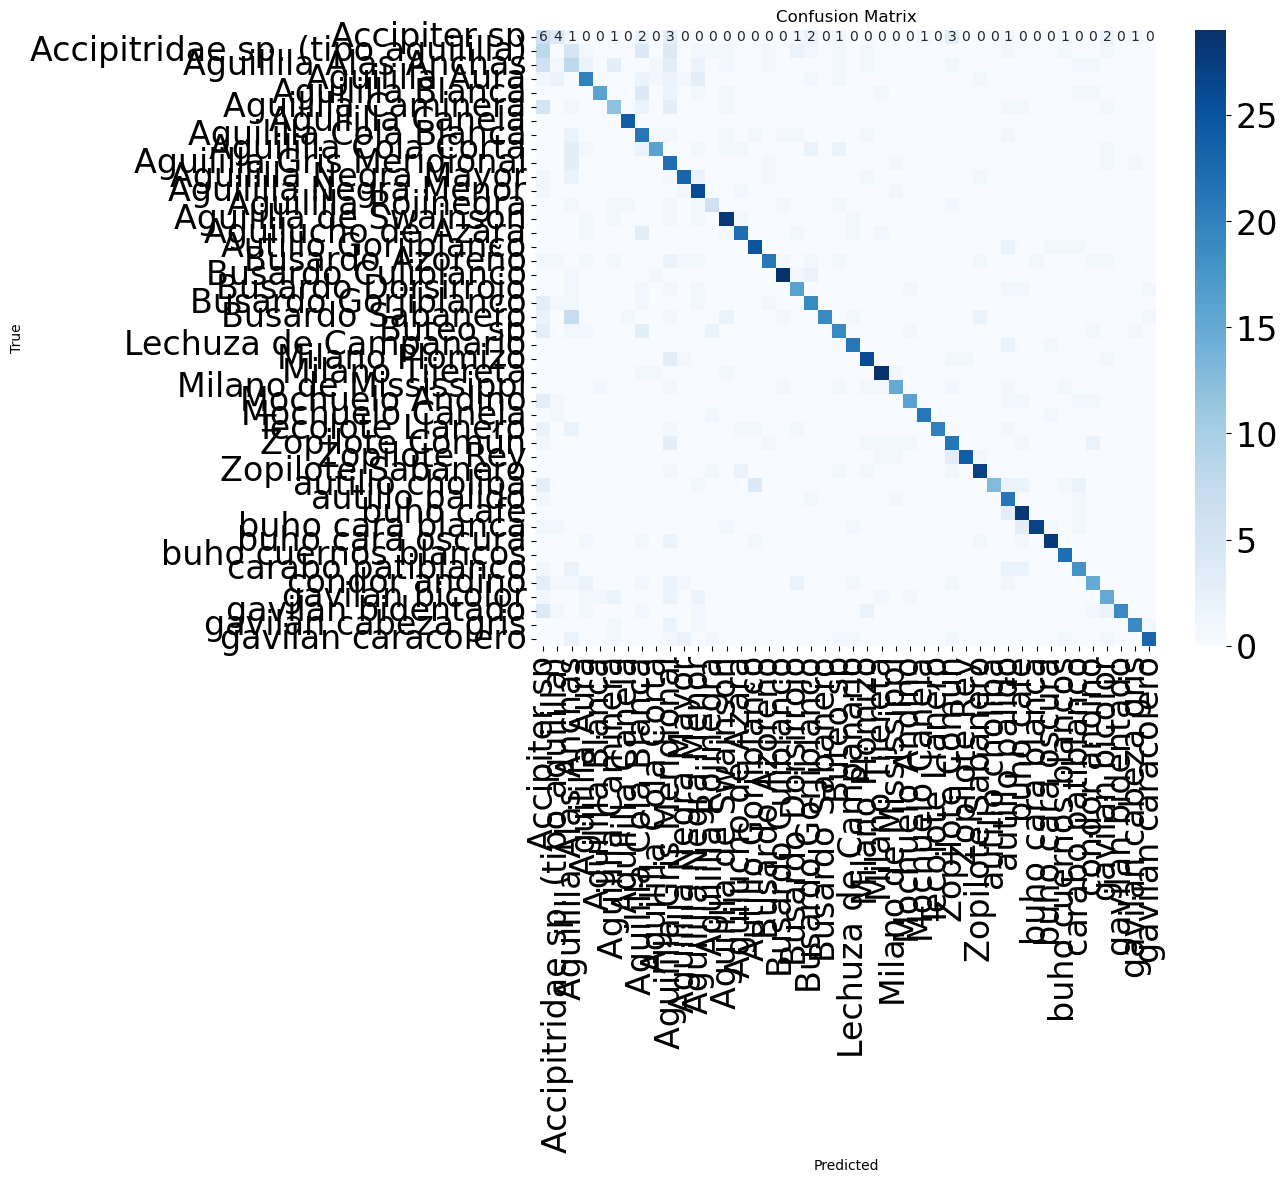

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Mostrar la matriz de confusión con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Matriz de confusion de las 10 primeras clases

In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que tienes al menos 10 clases en total
num_classes_to_plot = 10

# Filtrar las muestras que pertenecen solo a las primeras 10 clases
mask = (true_labels < num_classes_to_plot)
filtered_true_labels = true_labels[mask]
filtered_predicted_classes = predicted_classes[mask]

# Ajustar las predicciones para que solo consideren las clases entre 0 y 9
filtered_true_labels = filtered_true_labels[filtered_true_labels < num_classes_to_plot]
filtered_predicted_classes = filtered_predicted_classes[filtered_true_labels < num_classes_to_plot]

# Calcular la matriz de confusión para las primeras 10 clases
filtered_conf_matrix = confusion_matrix(filtered_true_labels, filtered_predicted_classes, labels=range(num_classes_to_plot))

# Calcular la matriz de confusión en términos de porcentaje global
total_samples = np.sum(filtered_conf_matrix)
conf_matrix_percentage = filtered_conf_matrix.astype('float') / total_samples * 100

# Mostrar la matriz de confusión con un mapa de calor solo para las primeras 10 clases (con porcentajes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=list(validation_generator.class_indices.keys())[:num_classes_to_plot], 
            yticklabels=list(validation_generator.class_indices.keys())[:num_classes_to_plot])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de confusion de las 10 primeras clases')
plt.show()


NameError: name 'true_labels' is not defined

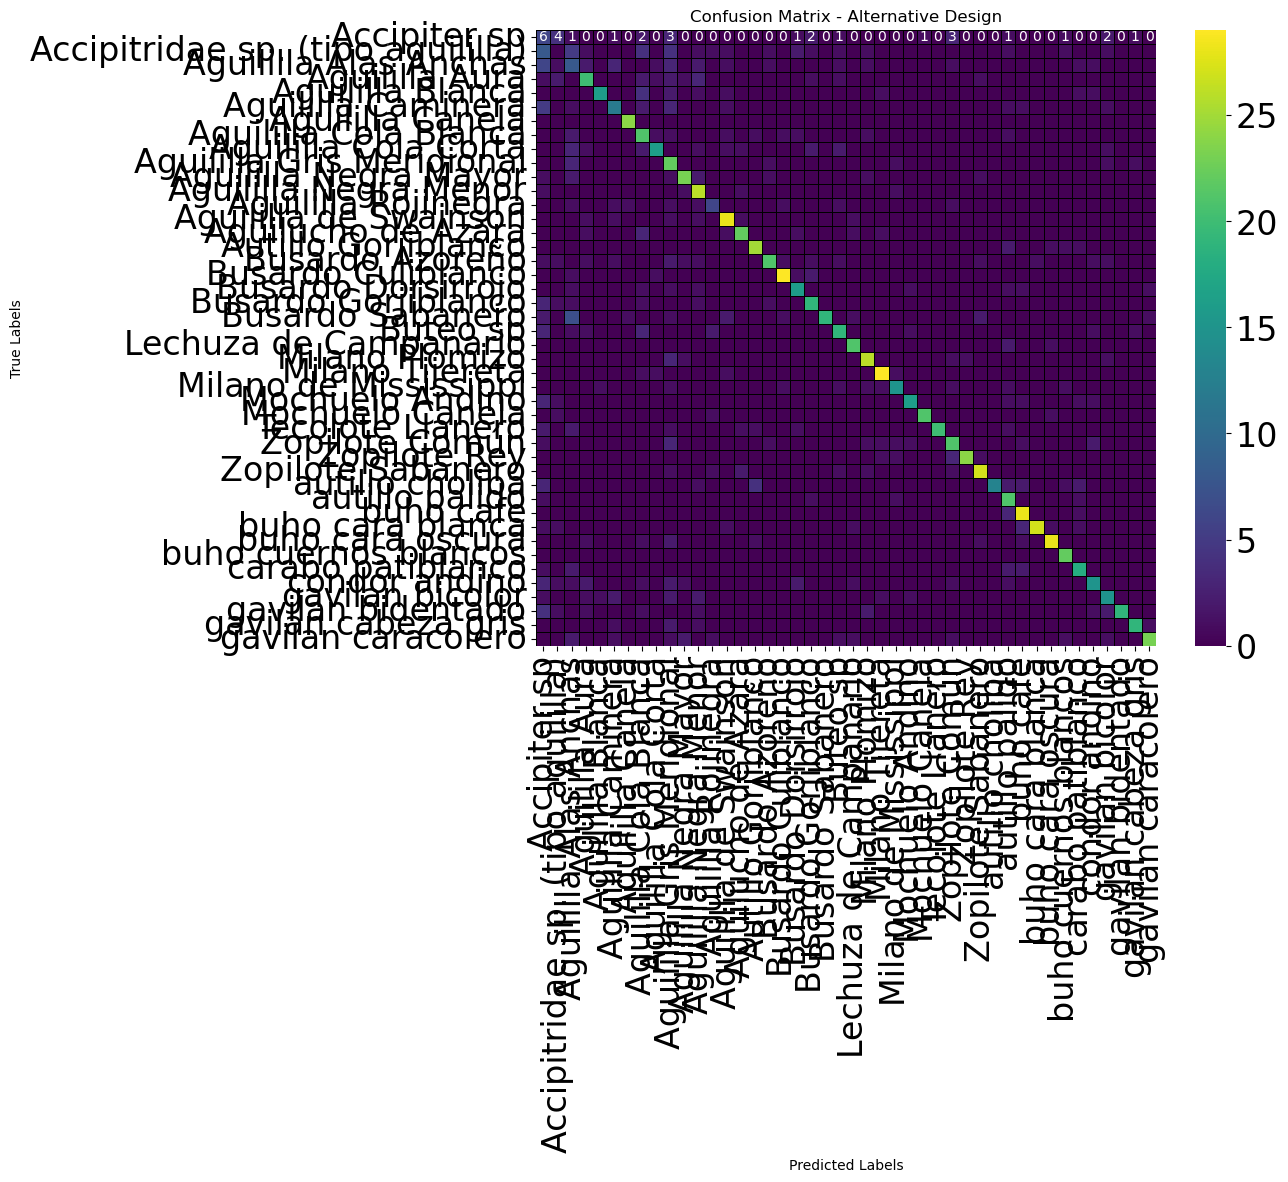

In [31]:
# Mostrar la matriz de confusión con un diseño diferente (diseño 2)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', linewidths=0.5, linecolor='black', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Alternative Design')
plt.show()

### Matriz de Confusión

Observando ambas representaciones, podemos notar que la mayoría de los valores se encuentran en la diagonal principal, lo cual indica que las clases fueron correctamente identificadas.

Sin embargo, hay cierta cantidad de errores (valores fuera de la diagonal), lo que nos muestra que el modelo tiene dificultades para diferenciar entre algunas clases. Por ejemplo, algunos valores notables fuera de la diagonal indican confusiones específicas entre clases similares.

In [32]:

# Calcular y mostrar el reporte de clasificación
report = classification_report(true_labels, predicted_classes, target_names=list(validation_generator.class_indices.keys()), digits=4)
print("\nReporte de Clasificación:")
print(report)


Reporte de Clasificación:
                                   precision    recall  f1-score   support

                     Accipiter sp     0.1053    0.2000    0.1379        30
Accipitridae sp. (tipo aguililla)     0.0000    0.0000    0.0000        34
            Aguililla Alas Anchas     0.1818    0.2424    0.2078        33
                   Aguililla Aura     0.6061    0.5714    0.5882        35
                 Aguililla Blanca     0.8889    0.5926    0.7111        27
               Aguililla Caminera     0.5217    0.4444    0.4800        27
                 Aguililla Canela     0.9231    1.0000    0.9600        24
            Aguililla Cola Blanca     0.4286    0.6774    0.5250        31
             Aguililla Cola Corta     0.7619    0.5333    0.6275        30
        Aguililla Gris Meridional     0.3385    0.7586    0.4681        29
            Aguililla Negra Mayor     0.7667    0.7188    0.7419        32
            Aguililla Negra Menor     0.5652    0.8667    0.6842        

### Reporte de Clasificación:

Podemos observar que la precisión y el recall varían significativamente entre diferentes clases. Algunas clases tienen una precisión bastante baja, lo cual puede indicar que el modelo tiene dificultades para distinguir esas clases de otras.

El valor de accuracy es de alrededor del 73.65%, lo cual indica un desempeño moderado. Las métricas como el macro avg y el weighted avg nos dan una visión más amplia de cómo se comportan las clases en conjunto, siendo la media ponderada un poco más alta, sugiriendo un sesgo hacia clases con más instancias.

#### Clases problematicas

Algunas clases tienen un bajo F1-Score, lo cual indica que el modelo necesita ser mejorado para identificar estas clases.

### Despliegue:

El modelo podría ser desplegado en una aplicación web o móvil